# 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import scipy
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import os 
import glob
import cv2
import itertools

from dataloader_distance import *

# Linear Regression : 분산 활용
- 보폭이 커질수록 분산이 커진다는 아이디어
- 거리의 경우 단위 환산이나 칼리브레이션, 노이즈 등에 약한 경향
    - 분산은 비교적 강건하다고 생각

In [2]:
file_path_train = "D:\gait_dataset/salted/train/*"
_, _, y_train = get_sensor_salted(file_path_train)
inputs_var_train = get_variance_salted(file_path_train)

file_path_test = "D:\gait_dataset/salted/test/*"
_, _, y_test = get_sensor_salted(file_path_test)
inputs_var_test  = get_variance_salted(file_path_test)

In [3]:
x_train = pd.DataFrame(inputs_var_train)
x_train.columns =  ['R_VAR_Y']

x_test = pd.DataFrame(inputs_var_test)
x_test.columns =  ['R_VAR_Y']

In [6]:
# x_train = pd.DataFrame(x_train.R_VAR_Y)
# x_test = pd.DataFrame(x_test.R_VAR_Y)
x_train

,R_VAR_Y
0,0.127714
1,0.114780
2,0.083197
3,0.092268
4,0.111765
...,...
3348,0.384486
3349,0.424381
3350,0.603237
3351,0.437574


In [7]:
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

In [8]:
MAE = mean_absolute_error(y_test, y_pred)
corr = np.corrcoef(y_test, y_pred)
print('MAE : {:.4f}, Corr : {:.4f}'.format(MAE, corr[0, 1]))

MAE : 11.9451, Corr : 0.9209


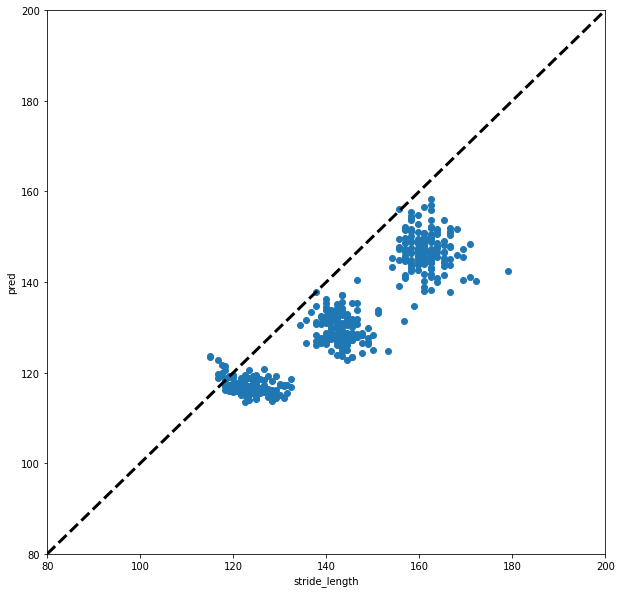

In [9]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlim([80, 200])
plt.xlabel('stride_length')
plt.ylim([80, 200])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

# Encoder-based Model : 최종 노드 1개

## No bias
- Best Result : Epoch 293, Valid Loss 10.571, MAE 2.500, Corr 0.986534

### 데이터 불러오기 

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

file_path = "D:\gait_dataset/salted/train/*"
dataset = Gait_Dataset_Salted(file_path, bias=False)
val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [5]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=128,
                                           shuffle=True,
                                           worker_init_fn=np.random.seed(42))
val_loader = torch.utils.data.DataLoader(val,
                                         batch_size=128,
                                         shuffle=False)

### Model & Scatter Plot
- 인코더에 Conv1d만을 사용
- 인코더의 아웃풋 길이가 늘어나 FC Layer의 수를 늘려 실험
    - FC Layer : enc_output -> 512 -> 256 -> 128 -> 64 -> 32 -> 1

In [11]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

SEED = 42
seed_everything(SEED) # Seed 고정

In [12]:
# # seed 고정
# random_seed=42
# torch.manual_seed(random_seed) # torch 
# torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
# torch.backends.cudnn.deterministic = True # cudnn
# torch.backends.cudnn.benchmark = False # cudnn
# np.random.seed(random_seed) # numpy
# random.seed(random_seed) # random
# os.environ["PYTHONHASHSEED"] = str(random_seed)


class Encoder(nn.Module):
    def __init__(self, input_dim, conv1d_dim1, conv1d_dim2, dense_dim):
        super(Encoder, self).__init__()
             
        self.conv1d_acc = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.conv1d_gyr = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.dense = nn.Sequential(
            nn.Linear(7744*2, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 1)
        )
        

    def forward(self, inputs_acc, inputs_gyr): 
        
        conv1d_output_acc = self.conv1d_acc(inputs_acc)
        conv1d_output_gyr = self.conv1d_gyr(inputs_gyr)
        
        enc_output = torch.concat((conv1d_output_acc, conv1d_output_gyr), 1)
        dense_output = self.dense(enc_output)
        
        return dense_output

In [13]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [14]:
# Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_corr = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_acc, inputs_gyr, stride_length, _, _ = data
        inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
        inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_acc, inputs_gyr)
        
        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()

        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_acc, inputs_gyr, stride_length, _, _ = data
            inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
            inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_acc, inputs_gyr)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    corr = torch.corrcoef(torch.stack([torch.squeeze(stride_length), torch.squeeze(outputs)]))[0, 1]
    
    
    print("Epoch : {}/{}, Train Loss : {:.3f}, Valid Loss {:.3f}, MAE {:.3f}, Corr {:3f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE, corr))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_corr = corr
        best_epoch = epoch+1
        torch.save(model.state_dict(), './model/encoder_1_best_ks30_nobias.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:.3f}, MAE {:.3f}, Corr {:3f}'.format(best_epoch, best, best_MAE, best_corr))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 6855.222, Valid Loss 941.109, MAE 23.247, Corr 0.647565
Best Valid Loss 941.1089
Epoch : 2/2000, Train Loss : 570.849, Valid Loss 332.813, MAE 17.012, Corr 0.650031
Best Valid Loss 332.8128
Epoch : 3/2000, Train Loss : 288.568, Valid Loss 277.714, MAE 15.237, Corr 0.652526
Best Valid Loss 277.7140
Epoch : 4/2000, Train Loss : 254.480, Valid Loss 243.855, MAE 14.136, Corr 0.654247
Best Valid Loss 243.8552
Epoch : 5/2000, Train Loss : 239.146, Valid Loss 265.664, MAE 14.385, Corr 0.656236
Epoch : 6/2000, Train Loss : 236.328, Valid Loss 240.630, MAE 14.170, Corr 0.660791
Best Valid Loss 240.6303
Epoch : 7/2000, Train Loss : 224.475, Valid Loss 234.258, MAE 14.008, Corr 0.665169
Best Valid Loss 234.2580


KeyboardInterrupt: 

In [7]:
### scatter plot
file_path = "D:\gait_dataset/salted/test/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path, normalization=True)
inputs_acc, inputs_gyr, stride_length = torch.Tensor(np.array(inputs_acc)), torch.Tensor(np.array(inputs_gyr)), torch.Tensor(np.array(stride_length))
inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)

In [8]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
model.load_state_dict(torch.load('./model/encoder_1_best_ks30_nobias.pth'))
model.eval()

Encoder(
  (conv1d_acc): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (conv1d_gyr): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (dense): Sequential(
    (0): Linear(in_features=15488, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

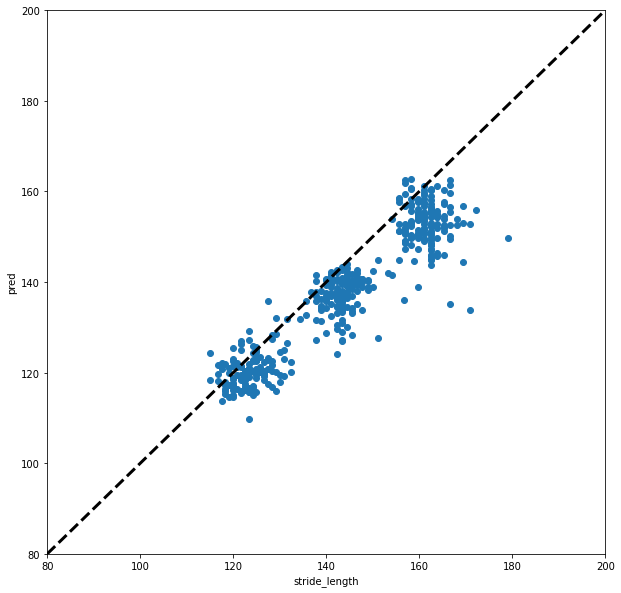

In [9]:
pred = model(inputs_acc, inputs_gyr).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, np.round(pred, 4))
plt.xlim([80, 200])
plt.xlabel('stride_length')
plt.ylim([80, 200])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

# Encoder-based Model : 3 node
- 최종적으로 출력된 노드 3개를 각 축별 variance와 곱

## Conv1d
- Best Result : Epoch 334, Valid Loss 10.259, MAE 2.099, Corr 0.982198

### 데이터 불러오기 

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

file_path = "D:\gait_dataset/salted/train/*"
dataset = Gait_Dataset_Salted(file_path, bias=False)
val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [35]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=128,
                                           shuffle=True,
                                           worker_init_fn=np.random.seed(42))
val_loader = torch.utils.data.DataLoader(val,
                                         batch_size=128,
                                         shuffle=False)

### Model & Scatter Plot
- Best Result : Epoch 259, Valid Loss 40.381912, MAE 4.223338

In [18]:
# seed 고정
random_seed=42
torch.manual_seed(random_seed) # torch 
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True # cudnn
torch.backends.cudnn.benchmark = False # cudnn
np.random.seed(random_seed) # numpy
random.seed(random_seed) # random

class Encoder_var(nn.Module):
    def __init__(self, input_dim, conv1d_dim1, conv1d_dim2, dense_dim):
        super(Encoder_var, self).__init__()
             
        self.conv1d_acc = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.conv1d_gyr = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.dense = nn.Sequential(
            nn.Linear(7744*2+1, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 1)
        )
        

    def forward(self, inputs_acc, inputs_gyr, inputs_var): 
        
        conv1d_output_acc = self.conv1d_acc(inputs_acc)
        conv1d_output_gyr = self.conv1d_gyr(inputs_gyr)
        
        enc_output = torch.concat((conv1d_output_acc, conv1d_output_gyr, inputs_var), 1)
        dense_output = self.dense(enc_output)
        
        return dense_output

In [19]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder_var(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [38]:
# Early Stopping을 위한 변수
best = 10000
converge_cnt = 0
best_MAE = 0
best_corr = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_acc, inputs_gyr, stride_length, _, inputs_var = data
        inputs_acc, inputs_gyr, stride_length, inputs_var = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_var.float()
        inputs_acc, inputs_gyr, inputs_var = inputs_acc.to(device), inputs_gyr.to(device), inputs_var.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_acc, inputs_gyr, inputs_var)

        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()
        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_acc, inputs_gyr, stride_length, _, inputs_var = data
            inputs_acc, inputs_gyr, stride_length, inputs_var = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_var.float()
            inputs_acc, inputs_gyr, inputs_var = inputs_acc.to(device), inputs_gyr.to(device), inputs_var.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_acc, inputs_gyr, inputs_var)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    corr = torch.corrcoef(torch.stack([torch.squeeze(stride_length), torch.squeeze(outputs)]))[0, 1]
    
    
    print("Epoch : {}/{}, Train Loss : {:.3f}, Valid Loss {:.3f}, MAE {:.3f}, Corr {:3f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE, corr))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_corr = corr
        best_epoch = epoch+1
        torch.save(model.state_dict(), './model/encoder_var_best_ks30_nobias.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:.3f}, MAE {:.3f}, Corr {:3f}'.format(best_epoch, best, best_MAE, best_corr))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 8304.344, Valid Loss 1020.572, MAE 26.810, Corr 0.402478
Best Valid Loss 1020.5718
Epoch : 2/2000, Train Loss : 619.964, Valid Loss 273.143, MAE 11.704, Corr 0.455382
Best Valid Loss 273.1435
Epoch : 3/2000, Train Loss : 299.716, Valid Loss 242.634, MAE 12.223, Corr 0.486699
Best Valid Loss 242.6339
Epoch : 4/2000, Train Loss : 242.862, Valid Loss 239.865, MAE 12.047, Corr 0.508657
Best Valid Loss 239.8646
Epoch : 5/2000, Train Loss : 241.043, Valid Loss 215.651, MAE 11.088, Corr 0.522293
Best Valid Loss 215.6507
Epoch : 6/2000, Train Loss : 237.381, Valid Loss 213.307, MAE 10.987, Corr 0.531522
Best Valid Loss 213.3067
Epoch : 7/2000, Train Loss : 239.448, Valid Loss 248.754, MAE 12.069, Corr 0.536339
Epoch : 8/2000, Train Loss : 247.396, Valid Loss 208.468, MAE 10.237, Corr 0.543124
Best Valid Loss 208.4675
Epoch : 9/2000, Train Loss : 231.460, Valid Loss 203.750, MAE 10.320, Corr 0.547148
Best Valid Loss 203.7500
Epoch : 10/2000, Train Loss : 234.138, Va

Epoch : 88/2000, Train Loss : 37.944, Valid Loss 27.039, MAE 3.024, Corr 0.982712
Epoch : 89/2000, Train Loss : 27.721, Valid Loss 34.031, MAE 3.690, Corr 0.983122
Epoch : 90/2000, Train Loss : 24.961, Valid Loss 20.295, MAE 2.190, Corr 0.983432
Best Valid Loss 20.2949
Epoch : 91/2000, Train Loss : 28.073, Valid Loss 32.946, MAE 3.623, Corr 0.982184
Epoch : 92/2000, Train Loss : 33.741, Valid Loss 23.129, MAE 2.623, Corr 0.983609
Epoch : 93/2000, Train Loss : 27.148, Valid Loss 39.946, MAE 4.975, Corr 0.982797
Epoch : 94/2000, Train Loss : 22.862, Valid Loss 25.355, MAE 2.850, Corr 0.984031
Epoch : 95/2000, Train Loss : 28.810, Valid Loss 42.935, MAE 5.186, Corr 0.983291
Epoch : 96/2000, Train Loss : 36.177, Valid Loss 23.770, MAE 2.901, Corr 0.982638
Epoch : 97/2000, Train Loss : 26.551, Valid Loss 20.298, MAE 2.203, Corr 0.983656
Epoch : 98/2000, Train Loss : 27.241, Valid Loss 19.202, MAE 2.256, Corr 0.983459
Best Valid Loss 19.2015
Epoch : 99/2000, Train Loss : 23.787, Valid Loss 2

Epoch : 183/2000, Train Loss : 16.924, Valid Loss 17.140, MAE 2.546, Corr 0.983843
Epoch : 184/2000, Train Loss : 46.087, Valid Loss 75.189, MAE 8.253, Corr 0.984503
Epoch : 185/2000, Train Loss : 38.029, Valid Loss 43.568, MAE 4.851, Corr 0.985611
Epoch : 186/2000, Train Loss : 28.275, Valid Loss 15.536, MAE 2.514, Corr 0.981227
Epoch : 187/2000, Train Loss : 16.274, Valid Loss 15.275, MAE 2.337, Corr 0.984950
Epoch : 188/2000, Train Loss : 16.835, Valid Loss 14.057, MAE 2.221, Corr 0.984547
Best Valid Loss 14.0574
Epoch : 189/2000, Train Loss : 15.797, Valid Loss 15.522, MAE 2.620, Corr 0.984259
Epoch : 190/2000, Train Loss : 14.286, Valid Loss 14.016, MAE 2.218, Corr 0.983748
Best Valid Loss 14.0164
Epoch : 191/2000, Train Loss : 14.198, Valid Loss 17.646, MAE 2.553, Corr 0.984116
Epoch : 192/2000, Train Loss : 21.267, Valid Loss 25.201, MAE 3.230, Corr 0.982743
Epoch : 193/2000, Train Loss : 16.888, Valid Loss 19.984, MAE 3.389, Corr 0.978937
Epoch : 194/2000, Train Loss : 16.640, 

Epoch : 278/2000, Train Loss : 15.328, Valid Loss 13.673, MAE 2.741, Corr 0.984306
Epoch : 279/2000, Train Loss : 16.016, Valid Loss 28.588, MAE 4.560, Corr 0.984482
Epoch : 280/2000, Train Loss : 11.683, Valid Loss 12.099, MAE 2.306, Corr 0.982721
Epoch : 281/2000, Train Loss : 11.134, Valid Loss 17.560, MAE 3.359, Corr 0.982349
Epoch : 282/2000, Train Loss : 13.054, Valid Loss 12.336, MAE 2.452, Corr 0.986147
Epoch : 283/2000, Train Loss : 10.775, Valid Loss 10.962, MAE 2.121, Corr 0.984400
Best Valid Loss 10.9625
Epoch : 284/2000, Train Loss : 10.645, Valid Loss 12.674, MAE 2.714, Corr 0.981620
Epoch : 285/2000, Train Loss : 12.904, Valid Loss 16.990, MAE 3.109, Corr 0.983089
Epoch : 286/2000, Train Loss : 11.406, Valid Loss 11.419, MAE 2.066, Corr 0.986280
Epoch : 287/2000, Train Loss : 13.703, Valid Loss 26.867, MAE 4.170, Corr 0.984239
Epoch : 288/2000, Train Loss : 17.385, Valid Loss 13.253, MAE 2.489, Corr 0.979823
Epoch : 289/2000, Train Loss : 12.539, Valid Loss 11.628, MAE 2

In [20]:
# scatter plot

file_path = "D:\gait_dataset/salted/test/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path, normalization=True)
inputs_var = get_variance_salted(file_path)
inputs_acc, inputs_gyr, stride_length, inputs_var = torch.Tensor(np.array(inputs_acc)), torch.Tensor(np.array(inputs_gyr)), torch.Tensor(np.array(stride_length)), torch.Tensor(np.array(inputs_var))
inputs_acc, inputs_gyr, stride_length, inputs_var = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_var.float()
inputs_acc, inputs_gyr, inputs_var = inputs_acc.to(device), inputs_gyr.to(device), inputs_var.to(device)

In [21]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder_var(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
model.load_state_dict(torch.load('./model/encoder_var_best_ks30_nobias.pth'))
model.eval()

Encoder_var(
  (conv1d_acc): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (conv1d_gyr): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (dense): Sequential(
    (0): Linear(in_features=15489, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

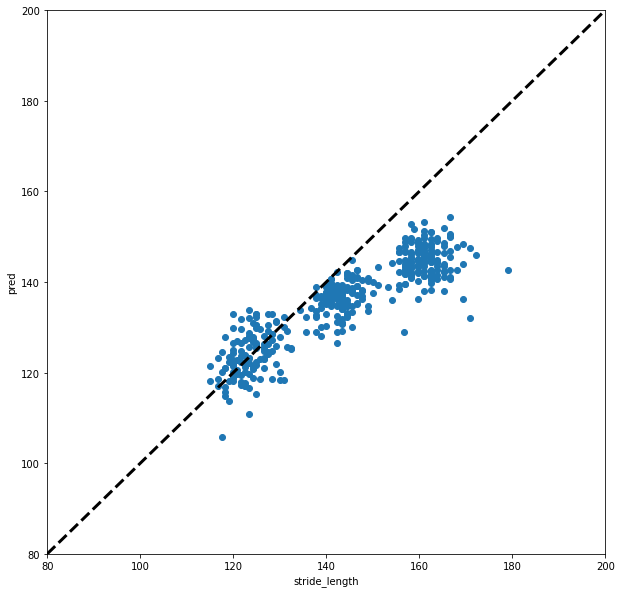

In [22]:
pred = model(inputs_acc, inputs_gyr, inputs_var).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, np.round(pred, 4))
plt.xlim([80, 200])
plt.xlabel('stride_length')
plt.ylim([80, 200])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

## LSTM
- Best Result : Epoch 301, Valid Loss 11.655, MAE 2.259, Corr 0.985151

### 데이터 불러오기 

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

file_path = "D:\gait_dataset/salted/train/*"
dataset = Gait_Dataset_Salted(file_path, bias=False)
val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [10]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=128,
                                           shuffle=True,
                                           worker_init_fn=np.random.seed(42))
val_loader = torch.utils.data.DataLoader(val,
                                         batch_size=128,
                                         shuffle=False)

### Model & Scatter Plot

In [41]:
# seed 고정
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class Encoder_lstm(nn.Module):
    def __init__(self, input_dim, lstm_dim, num_layers, dense_dim):
        super(Encoder_lstm, self).__init__()
        
        self.lstm_dim = lstm_dim
        self.num_layers = num_layers
             
        self.lstm_acc = nn.LSTM(input_dim, lstm_dim, num_layers, batch_first=True)
        self.lstm_gyr = nn.LSTM(input_dim, lstm_dim, num_layers, batch_first=True)
        
        self.dense = nn.Sequential(
            nn.Linear(lstm_dim*2, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 3)
        )
        

    def forward(self, inputs_acc, inputs_gyr, inputs_pst): 
        
        # 다음 학습에 영향을 주지 않기 위해 초기 h_0과 c_0 초기화
        h0 = torch.zeros(self.num_layers, inputs_acc.size(0), self.lstm_dim).to(device)
        c0 = torch.zeros(self.num_layers, inputs_acc.size(0), self.lstm_dim).to(device)
        
        lstm_output_acc = self.lstm_acc(inputs_acc)
        lstm_output_gyr = self.lstm_gyr(inputs_gyr)
        
        _, (h_acc, _) = self.lstm_acc(inputs_acc, (h0, c0))
        _, (h_gyr, _) = self.lstm_gyr(inputs_gyr, (h0, c0))
    
        enc_output = torch.cat((h_acc.view(-1, lstm_dim), h_gyr.view(-1, lstm_dim)), dim=1)
        dense_output = self.dense(enc_output)
        output = torch.unsqueeze(torch.sum(dense_output*inputs_pst, axis=1), 1)
        
        return output

In [42]:
input_dim = 300
lstm_dim = 64
num_layers = 1
dense_dim = 512


model = Encoder_lstm(input_dim, lstm_dim, num_layers, dense_dim).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [43]:
# Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_corr = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_acc, inputs_gyr, stride_length, inputs_pst = data
        inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
        inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_acc, inputs_gyr, inputs_pst)

        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()
        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_acc, inputs_gyr, stride_length, inputs_pst = data
            inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
            inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_acc, inputs_gyr, inputs_pst)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    corr = torch.corrcoef(torch.stack([torch.squeeze(stride_length), torch.squeeze(outputs)]))[0, 1]
    
    
    
    print("Epoch : {}/{}, Train Loss : {:.3f}, Valid Loss {:.3f}, MAE {:.3f}, Corr {:3f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE, corr))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_corr = corr
        best_epoch = epoch+1
        torch.save(model.state_dict(), './model/encoder_dist_best_ks30_bias.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:.3f}, MAE {:.3f}, Corr {:3f}'.format(best_epoch, best, best_MAE, best_corr))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 15213.859, Valid Loss 5106.789, MAE 67.893, Corr 0.658045
Epoch : 2/2000, Train Loss : 1523.620, Valid Loss 561.030, MAE 18.085, Corr 0.652574
Best Valid Loss 561.0302
Epoch : 3/2000, Train Loss : 347.202, Valid Loss 229.659, MAE 10.369, Corr 0.657544
Best Valid Loss 229.6589
Epoch : 4/2000, Train Loss : 223.382, Valid Loss 201.197, MAE 11.406, Corr 0.662875
Best Valid Loss 201.1974
Epoch : 5/2000, Train Loss : 200.994, Valid Loss 191.355, MAE 10.756, Corr 0.668398
Best Valid Loss 191.3547
Epoch : 6/2000, Train Loss : 194.898, Valid Loss 186.333, MAE 10.574, Corr 0.673361
Best Valid Loss 186.3332
Epoch : 7/2000, Train Loss : 190.556, Valid Loss 181.769, MAE 10.702, Corr 0.677284
Best Valid Loss 181.7691
Epoch : 8/2000, Train Loss : 186.695, Valid Loss 178.068, MAE 10.598, Corr 0.680634
Best Valid Loss 178.0680
Epoch : 9/2000, Train Loss : 183.684, Valid Loss 175.079, MAE 10.583, Corr 0.683594
Best Valid Loss 175.0790
Epoch : 10/2000, Train Loss : 182.196, V

Epoch : 88/2000, Train Loss : 35.032, Valid Loss 31.109, MAE 3.681, Corr 0.970174
Epoch : 89/2000, Train Loss : 35.504, Valid Loss 34.560, MAE 4.765, Corr 0.972631
Epoch : 90/2000, Train Loss : 36.118, Valid Loss 38.805, MAE 4.235, Corr 0.971888
Epoch : 91/2000, Train Loss : 31.583, Valid Loss 31.708, MAE 3.801, Corr 0.962828
Epoch : 92/2000, Train Loss : 26.188, Valid Loss 27.829, MAE 3.824, Corr 0.972040
Epoch : 93/2000, Train Loss : 30.700, Valid Loss 36.450, MAE 4.999, Corr 0.970228
Epoch : 94/2000, Train Loss : 31.840, Valid Loss 25.587, MAE 3.391, Corr 0.971617
Best Valid Loss 25.5870
Epoch : 95/2000, Train Loss : 25.128, Valid Loss 24.540, MAE 3.394, Corr 0.972327
Best Valid Loss 24.5395
Epoch : 96/2000, Train Loss : 25.149, Valid Loss 24.742, MAE 3.520, Corr 0.972162
Epoch : 97/2000, Train Loss : 25.595, Valid Loss 23.926, MAE 3.347, Corr 0.974940
Best Valid Loss 23.9265
Epoch : 98/2000, Train Loss : 24.093, Valid Loss 27.857, MAE 3.424, Corr 0.974765
Epoch : 99/2000, Train Los

Epoch : 183/2000, Train Loss : 15.414, Valid Loss 20.376, MAE 3.444, Corr 0.985579
Epoch : 184/2000, Train Loss : 16.142, Valid Loss 15.181, MAE 2.532, Corr 0.983142
Best Valid Loss 15.1813
Epoch : 185/2000, Train Loss : 16.632, Valid Loss 39.772, MAE 4.964, Corr 0.984323
Epoch : 186/2000, Train Loss : 22.185, Valid Loss 21.973, MAE 3.769, Corr 0.985043
Epoch : 187/2000, Train Loss : 14.513, Valid Loss 16.005, MAE 2.724, Corr 0.985812
Epoch : 188/2000, Train Loss : 19.993, Valid Loss 26.753, MAE 3.810, Corr 0.986217
Epoch : 189/2000, Train Loss : 19.549, Valid Loss 19.616, MAE 3.449, Corr 0.980759
Epoch : 190/2000, Train Loss : 19.172, Valid Loss 19.531, MAE 3.497, Corr 0.983451
Epoch : 191/2000, Train Loss : 17.726, Valid Loss 18.513, MAE 2.759, Corr 0.984117
Epoch : 192/2000, Train Loss : 15.017, Valid Loss 16.770, MAE 2.969, Corr 0.981801
Epoch : 193/2000, Train Loss : 15.447, Valid Loss 14.584, MAE 2.333, Corr 0.985500
Best Valid Loss 14.5842
Epoch : 194/2000, Train Loss : 16.468, 

Epoch : 278/2000, Train Loss : 11.242, Valid Loss 14.208, MAE 2.356, Corr 0.986430
Epoch : 279/2000, Train Loss : 12.654, Valid Loss 13.791, MAE 2.850, Corr 0.987479
Epoch : 280/2000, Train Loss : 12.481, Valid Loss 12.598, MAE 2.351, Corr 0.985075
Epoch : 281/2000, Train Loss : 11.923, Valid Loss 22.150, MAE 3.717, Corr 0.984056
Epoch : 282/2000, Train Loss : 16.314, Valid Loss 12.774, MAE 2.365, Corr 0.985624
Epoch : 283/2000, Train Loss : 9.928, Valid Loss 12.846, MAE 2.593, Corr 0.984866
Epoch : 284/2000, Train Loss : 12.739, Valid Loss 16.635, MAE 2.838, Corr 0.983157
Epoch : 285/2000, Train Loss : 12.400, Valid Loss 21.110, MAE 3.395, Corr 0.984945
Epoch : 286/2000, Train Loss : 14.165, Valid Loss 15.525, MAE 2.691, Corr 0.982817
Epoch : 287/2000, Train Loss : 11.521, Valid Loss 11.944, MAE 2.207, Corr 0.986639
Best Valid Loss 11.9437
Epoch : 288/2000, Train Loss : 13.580, Valid Loss 11.902, MAE 2.257, Corr 0.985525
Best Valid Loss 11.9023
Epoch : 289/2000, Train Loss : 10.642, V

In [44]:
# scatter plot

file_path = "D:\gait_dataset/salted/test/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path, normalization=True)
inputs_pst = get_position_salted(file_path, distance=True)
inputs_acc, inputs_gyr, stride_length, inputs_pst = torch.Tensor(np.array(inputs_acc)), torch.Tensor(np.array(inputs_gyr)), torch.Tensor(np.array(stride_length)), torch.Tensor(np.array(inputs_pst))
inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)

In [46]:
input_dim = 300
lstm_dim = 64
num_layers = 1
dense_dim = 512


model = Encoder_lstm(input_dim, lstm_dim, num_layers, dense_dim).to(device)
model.load_state_dict(torch.load('./model/encoder_dist_best_ks30_bias.pth'))
model.eval()

Encoder_lstm(
  (lstm_acc): LSTM(300, 64, batch_first=True)
  (lstm_gyr): LSTM(300, 64, batch_first=True)
  (dense): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=3, bias=True)
  )
)

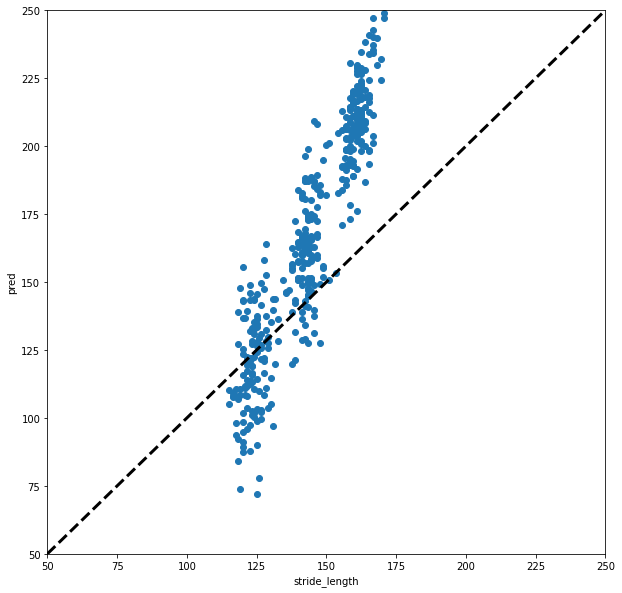

In [47]:
pred = model(inputs_acc, inputs_gyr, inputs_pst).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, np.round(pred, 4))
plt.xlim([50, 250])
plt.xlabel('stride_length')
plt.ylim([50, 250])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

## FC
- Best Result : Epoch 202, Valid Loss 15.980, MAE 2.838, Corr 0.978071

### 데이터 불러오기 

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

file_path = "D:\gait_dataset/salted/train/*"
dataset = Gait_Dataset_Salted(file_path, bias=False)
val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [10]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=128,
                                           shuffle=True,
                                           worker_init_fn=np.random.seed(42))
val_loader = torch.utils.data.DataLoader(val,
                                         batch_size=128,
                                         shuffle=False)

### Model & Scatter Plot

In [71]:
# seed 고정
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class Encoder_fc(nn.Module):
    def __init__(self, input_dim, dense_dim):
        super(Encoder_fc, self).__init__()
        
        self.fc_acc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 3)
        )
            
        self.fc_gyr = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 3)
        )
        

    def forward(self, inputs_acc, inputs_gyr, inputs_pst): 
        
        
        fc_output_acc = self.fc_acc(inputs_acc)
        fc_output_gyr = self.fc_gyr(inputs_gyr)
    
        enc_output = fc_output_acc+fc_output_gyr
        output = torch.unsqueeze(torch.sum(enc_output*inputs_pst, axis=1), 1)
        
        return output

In [72]:
input_dim = 900
dense_dim = 512


model = Encoder_fc(input_dim, dense_dim).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [73]:
# Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_corr = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_acc, inputs_gyr, stride_length, inputs_pst = data
        inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
        inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_acc, inputs_gyr, inputs_pst)

        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()
        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_acc, inputs_gyr, stride_length, inputs_pst = data
            inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
            inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_acc, inputs_gyr, inputs_pst)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    corr = torch.corrcoef(torch.stack([torch.squeeze(stride_length), torch.squeeze(outputs)]))[0, 1]
    
    
    
    print("Epoch : {}/{}, Train Loss : {:.3f}, Valid Loss {:.3f}, MAE {:.3f}, Corr {:3f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE, corr))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_corr = corr
        best_epoch = epoch+1
        torch.save(model.state_dict(), './model/encoder_fc_best_ks30_bias.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:.3f}, MAE {:.3f}, Corr {:3f}'.format(best_epoch, best, best_MAE, best_corr))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 10589.328, Valid Loss 2840.316, MAE 51.328, Corr 0.758227
Epoch : 2/2000, Train Loss : 792.145, Valid Loss 459.394, MAE 18.621, Corr 0.764055
Best Valid Loss 459.3944
Epoch : 3/2000, Train Loss : 262.022, Valid Loss 158.407, MAE 9.931, Corr 0.769647
Best Valid Loss 158.4069
Epoch : 4/2000, Train Loss : 184.241, Valid Loss 157.846, MAE 9.435, Corr 0.774622
Best Valid Loss 157.8457
Epoch : 5/2000, Train Loss : 168.792, Valid Loss 147.891, MAE 9.726, Corr 0.778792
Best Valid Loss 147.8908
Epoch : 6/2000, Train Loss : 164.063, Valid Loss 143.390, MAE 9.593, Corr 0.782603
Best Valid Loss 143.3895
Epoch : 7/2000, Train Loss : 159.547, Valid Loss 140.427, MAE 9.456, Corr 0.786012
Best Valid Loss 140.4275
Epoch : 8/2000, Train Loss : 156.333, Valid Loss 142.234, MAE 9.656, Corr 0.788876
Epoch : 9/2000, Train Loss : 154.132, Valid Loss 137.248, MAE 9.258, Corr 0.791679
Best Valid Loss 137.2480
Epoch : 10/2000, Train Loss : 151.609, Valid Loss 138.226, MAE 9.170, Cor

Epoch : 85/2000, Train Loss : 37.179, Valid Loss 42.752, MAE 4.843, Corr 0.964449
Epoch : 86/2000, Train Loss : 40.322, Valid Loss 40.290, MAE 4.565, Corr 0.973000
Epoch : 87/2000, Train Loss : 34.722, Valid Loss 33.300, MAE 3.989, Corr 0.971779
Best Valid Loss 33.3003
Epoch : 88/2000, Train Loss : 32.496, Valid Loss 48.852, MAE 5.101, Corr 0.967488
Epoch : 89/2000, Train Loss : 45.489, Valid Loss 44.193, MAE 4.824, Corr 0.967817
Epoch : 90/2000, Train Loss : 36.337, Valid Loss 31.580, MAE 3.588, Corr 0.971525
Best Valid Loss 31.5796
Epoch : 91/2000, Train Loss : 31.100, Valid Loss 33.198, MAE 4.072, Corr 0.971403
Epoch : 92/2000, Train Loss : 33.841, Valid Loss 33.444, MAE 3.707, Corr 0.972700
Epoch : 93/2000, Train Loss : 31.109, Valid Loss 29.741, MAE 3.412, Corr 0.973569
Best Valid Loss 29.7413
Epoch : 94/2000, Train Loss : 33.638, Valid Loss 29.517, MAE 3.371, Corr 0.970120
Best Valid Loss 29.5175
Epoch : 95/2000, Train Loss : 29.154, Valid Loss 31.482, MAE 3.970, Corr 0.972580
Ep

Epoch : 178/2000, Train Loss : 17.237, Valid Loss 22.629, MAE 3.883, Corr 0.973554
Epoch : 179/2000, Train Loss : 24.830, Valid Loss 17.629, MAE 2.889, Corr 0.977238
Best Valid Loss 17.6286
Epoch : 180/2000, Train Loss : 20.937, Valid Loss 18.071, MAE 2.975, Corr 0.974878
Epoch : 181/2000, Train Loss : 17.749, Valid Loss 24.796, MAE 3.082, Corr 0.980354
Epoch : 182/2000, Train Loss : 19.651, Valid Loss 18.884, MAE 3.202, Corr 0.973285
Epoch : 183/2000, Train Loss : 18.335, Valid Loss 19.902, MAE 3.347, Corr 0.979243
Epoch : 184/2000, Train Loss : 16.851, Valid Loss 24.076, MAE 3.902, Corr 0.977654
Epoch : 185/2000, Train Loss : 16.595, Valid Loss 29.445, MAE 4.214, Corr 0.976060
Epoch : 186/2000, Train Loss : 17.311, Valid Loss 20.084, MAE 3.017, Corr 0.978628
Epoch : 187/2000, Train Loss : 17.005, Valid Loss 22.396, MAE 3.126, Corr 0.980426
Epoch : 188/2000, Train Loss : 19.342, Valid Loss 18.198, MAE 2.634, Corr 0.977286
Epoch : 189/2000, Train Loss : 17.405, Valid Loss 17.067, MAE 2

In [76]:
# scatter plot

file_path = "D:\gait_dataset/salted/test/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path, normalization=True)
inputs_pst = get_position_salted(file_path, distance=True)
inputs_acc, inputs_gyr, stride_length, inputs_pst = torch.Tensor(np.array(inputs_acc)), torch.Tensor(np.array(inputs_gyr)), torch.Tensor(np.array(stride_length)), torch.Tensor(np.array(inputs_pst))
inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)

In [78]:
input_dim = 900
dense_dim = 512


model = Encoder_fc(input_dim, dense_dim).to(device)
model.load_state_dict(torch.load('./model/encoder_fc_best_ks30_bias.pth'))
model.eval()

Encoder_fc(
  (fc_acc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=900, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=64, out_features=3, bias=True)
  )
  (fc_gyr): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=900, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=64, out_features=3, bias=True)
  )
)

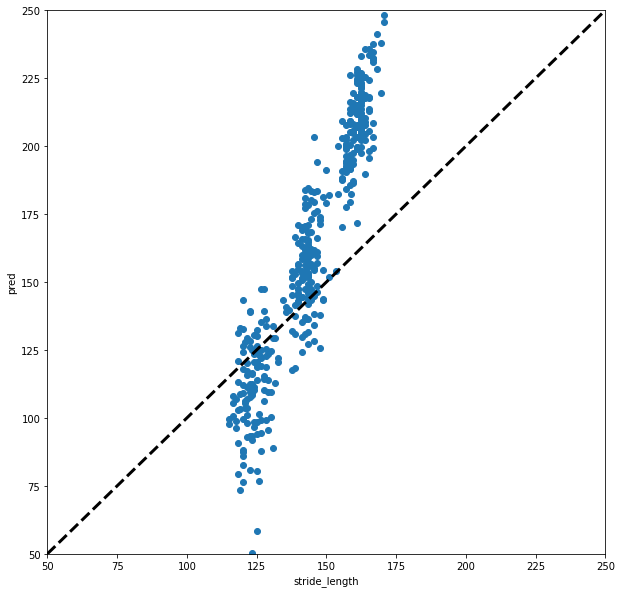

In [79]:
pred = model(inputs_acc, inputs_gyr, inputs_pst).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, np.round(pred, 4))
plt.xlim([50, 250])
plt.xlabel('stride_length')
plt.ylim([50, 250])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

# Encoder-based Model : Acc, Gyro 축별 입력
- 각 축 Acc에서 얻어진 축별 distance를 곱해주기 때문에 축별로 데이터를 입력
    - 축별 Acc/Gyro의 정보가 알맞은 축의 distance와 곱해져야 한다는 생각에 시도
- 3개의 인코더에는 각각 (Acc_x, Gyro_x) / (Acc_y, Gyro_y) / (Acc_z, Gyro_z)가 입력으로 들어감
    - 인코더의 각 output을 concat한 뒤 FC-Layer에 넣었을 때, 축별 정보가 순서대로 보존될 수 있을지는 의문 부호 
- Pressure는 축이 따로 없으므로 고려하지 않음

In [136]:
file_path = "D:\gait_dataset/salted/train/*"
dataset = Gait_Dataset_Axis_Salted(file_path)
val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [137]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=128,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val,
                                         batch_size=128,
                                         shuffle=False)

In [138]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

class Encoder_axis(nn.Module):
    def __init__(self, input_dim, dense_dim):
        super(Encoder_axis, self).__init__()
        
        
        self.fc_x = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 1)
        )
        
        self.fc_y = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 1)
        )
        
        self.fc_z = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 1)
        )
        
        

    def forward(self, inputs_x, inputs_y, inputs_z): 
        

        fc_output_x = self.fc_x(inputs_x)
        fc_output_y = self.fc_y(inputs_y)
        fc_output_z = self.fc_z(inputs_z)
        
        
        enc_output = torch.concat((fc_output_x, fc_output_y, fc_output_z), 1)
        output = torch.unsqueeze(torch.sum(enc_output*inputs_pst, axis=1), 1)

        return output

In [139]:
input_dim = 600
dense_dim = 512

model = Encoder_axis(input_dim, dense_dim).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [140]:
# Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = data
        inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = inputs_x.float(), inputs_y.float(), inputs_z.float(), stride_length.float(), inputs_pst.float()
        inputs_x, inputs_y, inputs_z, inputs_pst = inputs_x.to(device), inputs_y.to(device), inputs_z.to(device), inputs_pst.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_x, inputs_y, inputs_z)
        
        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()
        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = data
            inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = inputs_x.float(), inputs_y.float(), inputs_z.float(), stride_length.float(), inputs_pst.float()
            inputs_x, inputs_y, inputs_z, inputs_pst = inputs_x.to(device), inputs_y.to(device), inputs_z.to(device), inputs_pst.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_x, inputs_y, inputs_z)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    
    
    print("Epoch : {}/{}, Train Loss : {:.6f}, Valid Loss {:.6f}, MAE {:.6f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_epoch = epoch+1
        torch.save(model.state_dict(), './encoder_axis_best.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:4f}, MAE {:4f}'.format(best_epoch, best, best_MAE))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 4204.483070, Valid Loss 960.211477, MAE 18.732618
Best Valid Loss 960.2115
Epoch : 2/2000, Train Loss : 740.092518, Valid Loss 682.783244, MAE 21.815802
Best Valid Loss 682.7832
Epoch : 3/2000, Train Loss : 672.514692, Valid Loss 643.312449, MAE 20.371880
Best Valid Loss 643.3124
Epoch : 4/2000, Train Loss : 654.339292, Valid Loss 623.736908, MAE 19.857491
Best Valid Loss 623.7369
Epoch : 5/2000, Train Loss : 643.132443, Valid Loss 608.725906, MAE 19.476088
Best Valid Loss 608.7259
Epoch : 6/2000, Train Loss : 629.894007, Valid Loss 597.531306, MAE 19.109816
Best Valid Loss 597.5313
Epoch : 7/2000, Train Loss : 618.994101, Valid Loss 586.731923, MAE 18.686306
Best Valid Loss 586.7319
Epoch : 8/2000, Train Loss : 620.693370, Valid Loss 594.880473, MAE 19.484201
Epoch : 9/2000, Train Loss : 599.383153, Valid Loss 564.362340, MAE 18.882992
Best Valid Loss 564.3623
Epoch : 10/2000, Train Loss : 597.239210, Valid Loss 600.098083, MAE 17.494865
Epoch : 11/2000, T

Epoch : 95/2000, Train Loss : 254.135312, Valid Loss 237.997208, MAE 13.818307
Best Valid Loss 237.9972
Epoch : 96/2000, Train Loss : 218.618420, Valid Loss 240.439158, MAE 13.829137
Epoch : 97/2000, Train Loss : 224.414599, Valid Loss 356.595851, MAE 14.280470
Epoch : 98/2000, Train Loss : 228.745526, Valid Loss 237.988360, MAE 13.156813
Best Valid Loss 237.9884
Epoch : 99/2000, Train Loss : 222.886017, Valid Loss 256.208115, MAE 14.809103
Epoch : 100/2000, Train Loss : 243.921161, Valid Loss 244.645859, MAE 13.140440
Epoch : 101/2000, Train Loss : 269.264781, Valid Loss 447.129400, MAE 14.575147
Epoch : 102/2000, Train Loss : 261.608053, Valid Loss 245.502991, MAE 14.338456
Epoch : 103/2000, Train Loss : 233.777489, Valid Loss 413.139114, MAE 14.149916
Epoch : 104/2000, Train Loss : 251.044906, Valid Loss 250.410014, MAE 14.467360
Epoch : 105/2000, Train Loss : 207.769081, Valid Loss 253.500000, MAE 14.559004
Epoch : 106/2000, Train Loss : 230.540902, Valid Loss 244.426598, MAE 13.54

In [141]:
file_path = "D:\gait_dataset/salted/test/*"
inputs_x, inputs_y, inputs_z, stride_length = get_axis_sensor_salted(file_path)
inputs_pst = get_position_salted(file_path, distance=True)
inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = torch.Tensor(np.array(inputs_x)), torch.Tensor(np.array(inputs_y)), torch.Tensor(np.array(inputs_z)), torch.Tensor(np.array(stride_length)), torch.Tensor(np.array(inputs_pst))
inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = inputs_x.float(), inputs_y.float(), inputs_z.float(), stride_length.float(), inputs_pst.float()
inputs_x, inputs_y, inputs_z, inputs_pst = inputs_x.to(device), inputs_y.to(device), inputs_z.to(device), inputs_pst.to(device)

# stride_length = stride_length.reshape(-1, 1)
# stride_length = stride_length.to(device)

In [143]:
input_dim = 600
dense_dim = 512

model = Encoder_axis(input_dim, dense_dim).to(device)
model.load_state_dict(torch.load('./encoder_axis_best.pth'))
model.eval()

Encoder_axis(
  (fc_x): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=600, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
  (fc_y): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=600, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
  (fc_z): Sequ

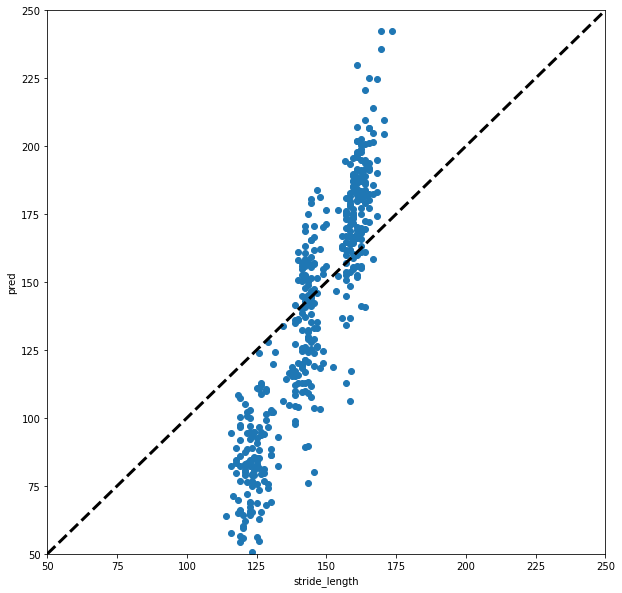

In [146]:
pred = model(inputs_x, inputs_y, inputs_z).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, np.round(pred, 4))
plt.xlim([50, 250])
plt.xlabel('stride_length')
plt.ylim([50, 250])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
from torch.utils.data import Dataset, DataLoader, random_split

import os 
import glob
import cv2
import itertools



class Gait_Dataset_Salted(Dataset):
    def __init__(self, file_path, bias=False):
        self.bias = bias
        self.file_path = file_path
        self.inputs_acc, self.inputs_gyr, self.stride_length = get_sensor_salted(file_path, bias=bias)
#         self.inputs_spd = get_speed_salted(file_path)
        self.inputs_pst = get_position_salted(file_path, distance=True, bias=bias)
        
    def __len__(self) :
        return len(self.inputs_acc)
    
    def __getitem__(self, idx):
        return self.inputs_acc[idx], self.inputs_gyr[idx], self.stride_length[idx], self.inputs_pst[idx]
    
    
class Gait_Dataset_Axis_Salted(Dataset):
    def __init__(self, file_path, axis=None):
        self.file_path = file_path
        self.inputs_x, self.inputs_y, self.inputs_z, self.stride_length = get_axis_sensor_salted(file_path)
        self.inputs_pst = get_position_salted(file_path, distance=True)
        
    def __len__(self) :
        return len(self.stride_length)
    
    def __getitem__(self, idx):
        return self.inputs_x[idx], self.inputs_y[idx], self.inputs_z[idx], self.stride_length[idx], self.inputs_pst[idx]



def get_event_salted(file_path):
    
    df = pd.read_csv(file_path, skiprows=2)
    
    # 압력값 불러오기
    prs = df.filter(regex="R_value")
    prs_mean = np.mean(prs.iloc[:, 0:4], axis=1) 
    
    # Gaussian Filter : Smoothing pressure data
    prs_mean_gf = pd.Series(scipy.ndimage.gaussian_filter1d(prs_mean, 2))
    
    # Level Shift 
    lev_idx = prs_mean_gf > 5 # 가우시안 필터로 인해 0이 아닌 값으로 threshold 설정
    prs_lev = lev_idx.map(lambda x : 1 if x else 0)
    
    # HS, TO Index 추출
    event_idx = []
    for i in range(len(prs_lev)-1):
        if (prs_lev[i] - prs_lev[i+1]) != 0:
            event_idx.append(i)
            
    # HS 이벤트가 먼저 시작하도록 : 나중에 lev shift를 통해 구하는 방법으로 변경하는 것도 괜찮을 듯
    if np.diff(event_idx)[0] < np.diff(event_idx)[1]: # Swing Phase가 Stand Phase보다 길다는 것을 가정 : 장애 데이터에서도 확인 필요
        del event_idx[0]
    
    
    return event_idx

def get_sensor_salted(file_path, normalization=True, bias=False):
    inputs_acc = []
    inputs_gyr = []
    stride_length = []
    for file_name in glob.glob(file_path):
        df = pd.read_csv(file_name, skiprows=2)
        acc = df.filter(regex="R_ACC")
        gyr = df.filter(regex="R_GYRO")
        event_idx = get_event_salted(file_name)

        # HS 이벤트 추출
        event_hs = event_idx[0::2]

        # m/s^2 단위 변환
        acc = acc / 1000 * 9.8066
        
        # x축과 z축에 적용되는 bias 제거(z축의 경우 중력가속도)
        if bias == False:
            acc['R_ACC_X']= acc['R_ACC_X'] - np.mean(acc['R_ACC_X'])
            acc['R_ACC_Z']= acc['R_ACC_Z'] - np.mean(acc['R_ACC_Z']) 
        
        # Normalization
        if normalization == True:
            scaler = MinMaxScaler()
            acc_norm = scaler.fit_transform(acc)
            gyr_norm = scaler.fit_transform(gyr)

        # 가속도와 자이로 센서 값
        for i in range(1, len(event_hs)):
            if normalization == True:
                inputs_acc.append(np.transpose(cv2.resize(acc_norm[event_hs[i-1]:event_hs[i]], dsize=(3, 300))))
                inputs_gyr.append(np.transpose(cv2.resize(gyr_norm[event_hs[i-1]:event_hs[i]], dsize=(3, 300))))
            else:
                inputs_acc.append(np.transpose(acc[event_hs[i-1]:event_hs[i]]))
                inputs_gyr.append(np.transpose(gyr[event_hs[i-1]:event_hs[i]]))

            #             inputs_gyr.append(acc_norm[event_hs[i-1]:event_hs[i]])
    
        if '3km' in file_name:
            stride_length.append(np.diff(event_hs) * (3000/3600))
        elif '4km' in file_name:
            stride_length.append(np.diff(event_hs) * (4000/3600))
        else:
            stride_length.append(np.diff(event_hs) * (5000/3600))
            
    stride_length = np.round(np.array(list(itertools.chain.from_iterable(stride_length))), 3)
    
    return inputs_acc, inputs_gyr, stride_length

def get_axis_sensor_salted(file_path, normalization=True, bias=False):
    inputs_x = []
    inputs_y = []
    inputs_z = []
    stride_length = []
    for file_name in glob.glob(file_path):
        df = pd.read_csv(file_name, skiprows=2)
        acc = df.filter(regex="R_ACC")
        gyr = df.filter(regex="R_GYRO")
        event_idx = get_event_salted(file_name)

        # HS 이벤트 추출
        event_hs = event_idx[0::2]

        # m/s^2 단위 변환
        acc = acc / 1000 * 9.8066
        
        # x축과 z축에 적용되는 bias 제거(z축의 경우 중력가속도)
        if bias == False:
            acc['R_ACC_X']= acc['R_ACC_X'] - np.mean(acc['R_ACC_X'])
            acc['R_ACC_Z']= acc['R_ACC_Z'] - np.mean(acc['R_ACC_Z']) 

        # Normalization
        if normalization == True:
            scaler = MinMaxScaler()
            acc_norm = scaler.fit_transform(acc)
            gyr_norm = scaler.fit_transform(gyr)

            
        # 가속도와 자이로 센서 값
        for i in range(1, len(event_hs)):
            if normalization == True:
                inputs_x.append(np.vstack([np.transpose(cv2.resize(acc_norm[:, 0][event_hs[i-1]:event_hs[i]], dsize=(1, 300))), 
                                           np.transpose(cv2.resize(gyr_norm[:, 0][event_hs[i-1]:event_hs[i]], dsize=(1, 300)))]))
                inputs_y.append(np.vstack([np.transpose(cv2.resize(acc_norm[:, 1][event_hs[i-1]:event_hs[i]], dsize=(1, 300))), 
                                           np.transpose(cv2.resize(gyr_norm[:, 1][event_hs[i-1]:event_hs[i]], dsize=(1, 300)))]))
                inputs_z.append(np.vstack([np.transpose(cv2.resize(acc_norm[:, 2][event_hs[i-1]:event_hs[i]], dsize=(1, 300))), 
                                           np.transpose(cv2.resize(gyr_norm[:, 2][event_hs[i-1]:event_hs[i]], dsize=(1, 300)))]))
            else:
                inputs_acc.append(np.transpose(acc[event_hs[i-1]:event_hs[i]]))
                inputs_gyr.append(np.transpose(gyr[event_hs[i-1]:event_hs[i]]))

    
        if '3km' in file_name:
            stride_length.append(np.diff(event_hs) * (3000/3600))
        elif '4km' in file_name:
            stride_length.append(np.diff(event_hs) * (4000/3600))
        else:
            stride_length.append(np.diff(event_hs) * (5000/3600))
            
    stride_length = np.round(np.array(list(itertools.chain.from_iterable(stride_length))), 3)
    
    return inputs_x, inputs_y, inputs_z, stride_length



def get_speed_salted(file_path, bias=False):
    bias = bias
    inputs_acc, _, _ = get_sensor_salted(file_path, normalization=False, bias=bias)
    inputs_spd = []
    for i in range(len(inputs_acc)):
        spd = pd.DataFrame(scipy.integrate.cumulative_trapezoid(inputs_acc[i], dx=(1/100)))
        inputs_spd.append(spd) #m/s
    return inputs_spd

def get_position_salted(file_path, distance=False, bias=False):
    bias = bias
    inputs_spd = get_speed_salted(file_path, bias = bias)
    inputs_pst = []
    for i in range(len(inputs_spd)):
        pst = pd.DataFrame(scipy.integrate.cumulative_trapezoid(inputs_spd[i], dx=(1/100)))
        if distance==True:
            pst = np.array(np.sum(pst, axis=1))
        inputs_pst.append(pst)
    
    scaler = MinMaxScaler()
    inputs_pst = scaler.fit_transform(inputs_pst)

        
    return inputs_pst

def get_variance_salted(file_path):
    inputs_acc, _, _ = get_sensor_salted(file_path, normalization=False)
    inputs_var = []
    for i in range(len(inputs_acc)):
        var = np.round(np.var(inputs_acc[i], axis=1), 3)
        inputs_var.append(var.R_ACC_Y)
        
    scaler = MinMaxScaler()
    inputs_var = scaler.fit_transform(np.array(inputs_var).reshape(-1, 1))
        
    return inputs_var


In [6]:
file_path = "D:\gait_dataset/salted/train/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path, normalization=False)
inputs_pst = get_position_salted(file_path, distance=True)
inputs_spd = get_speed_salted(file_path)

In [21]:
file_path = "D:\gait_dataset/salted/train/*"
inputs_var = get_variance_salted(file_path)

In [25]:
len(inputs_var)

3354

In [22]:
inputs_var

array([[0.10413433],
       [0.11739076],
       [0.09784379],
       ...,
       [0.53455985],
       [0.4229858 ],
       [0.43181979]])

In [17]:
inputs_var

[35.06,
 37.494,
 33.905,
 31.88,
 34.03,
 35.881,
 34.61,
 37.281,
 59.813,
 40.128,
 40.907,
 40.542,
 39.412,
 37.545,
 48.664,
 37.275,
 37.027,
 34.674,
 62.878,
 45.535,
 36.229,
 33.713,
 30.694,
 35.6,
 29.757,
 32.264,
 31.648,
 31.701,
 36.821,
 31.449,
 34.858,
 45.855,
 33.148,
 34.559,
 48.648,
 52.08,
 49.405,
 39.234,
 41.355,
 39.04,
 37.97,
 40.989,
 37.816,
 33.907,
 39.511,
 38.779,
 35.271,
 39.267,
 35.838,
 37.351,
 40.167,
 34.93,
 31.886,
 33.117,
 34.874,
 34.29,
 38.522,
 38.837,
 37.799,
 40.048,
 32.912,
 32.332,
 42.453,
 38.716,
 42.884,
 40.23,
 36.438,
 32.454,
 37.604,
 37.842,
 43.564,
 30.65,
 41.029,
 42.55,
 38.505,
 37.227,
 43.023,
 38.128,
 38.534,
 34.421,
 35.216,
 38.155,
 33.521,
 35.323,
 33.888,
 39.707,
 35.605,
 37.598,
 36.424,
 33.802,
 33.48,
 41.089,
 34.072,
 43.484,
 40.183,
 38.255,
 36.917,
 38.097,
 40.641,
 41.215,
 37.043,
 36.492,
 36.145,
 42.84,
 42.054,
 37.501,
 40.473,
 34.897,
 41.022,
 38.712,
 35.741,
 39.265,
 45.135,

In [7]:
inputs_acc[0]

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
R_ACC_X,0.062411,-0.967282,0.317382,2.386575,1.700113,0.533128,0.395835,-0.163141,-0.771150,-0.996702,...,-1.398773,-0.908443,-0.908443,-0.418113,0.003571,0.189897,0.023184,-0.604438,-0.310240,0.582161
R_ACC_Y,-0.382457,-2.245711,-3.608829,-1.510216,-0.804141,-0.460910,-0.107873,-0.117679,0.362844,1.372924,...,14.396089,16.327989,16.327989,18.357955,20.132950,21.398001,21.956977,22.221756,22.555180,22.829765
R_ACC_Z,9.052672,1.609462,-0.646056,1.050486,-0.018433,-1.263872,-0.577410,-0.989287,-2.401437,-2.313178,...,-6.039686,-3.980300,-3.980300,-2.018980,-0.243985,1.217198,2.188052,1.070099,1.246618,0.618996


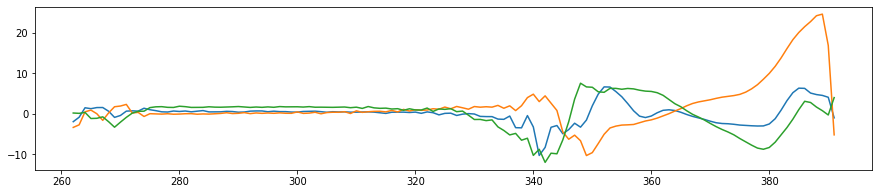

In [15]:
plt.figure(figsize=(15, 3))
plt.plot(inputs_acc[2].transpose())

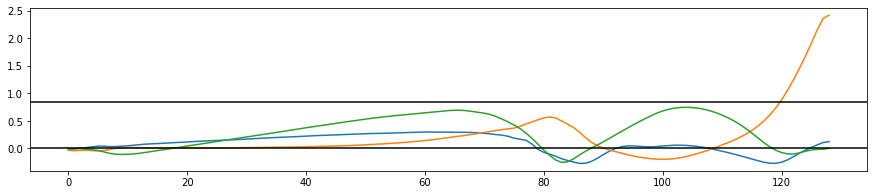

In [16]:
spd = scipy.integrate.cumulative_trapezoid(inputs_acc[2], dx=1/100)
plt.figure(figsize=(15, 3))
plt.plot(pd.DataFrame(spd.transpose()))
plt.axhline(y=0, color='k')
plt.axhline(y=0.833, color='k')

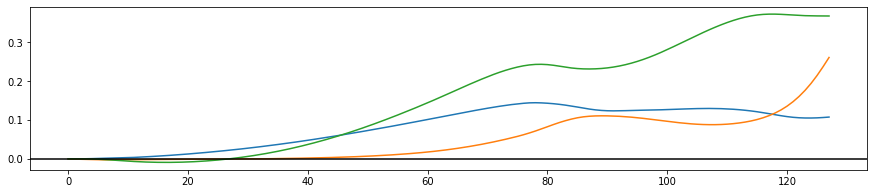

In [17]:
pst = scipy.integrate.cumulative_trapezoid(spd, dx=(1/100))
plt.figure(figsize=(15, 3))
plt.plot(pd.DataFrame(pst.transpose()))
plt.axhline(y=0, color='k')
